In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio


from matplotlib.pyplot import imread
import cv2

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files   

In [5]:
## Load Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [6]:
## Load HR Images from the directory

hr_tumor_files = load_data("../input/espcn-tumor-dataset/hr_tumor/hr_tumor_imgs/", ".jpeg")

directory path:  ../input/espcn-tumor-dataset/hr_tumor/hr_tumor_imgs/
directories:  ['../input/espcn-tumor-dataset/hr_tumor/hr_tumor_imgs/']
list of files:  200
list of files path:  200 file path:  ../input/espcn-tumor-dataset/hr_tumor/hr_tumor_imgs/HRTMR_83.jpeg
Files Read:  200


In [7]:
## Convert each jpeg image to UMat format to apply polygon curve approximation in opencv2

hr_tumors = []
for i in range(len(hr_tumor_files)):
    hr_tumors.append(cv2.cvtColor(cv2.UMat(hr_tumor_files[i]), cv2.COLOR_RGB2GRAY))

In [8]:
## Function to display UMat images

def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].get().astype('f'))
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

In [9]:
## Function to display numpy images of Tumor

def displayTumors(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].astype('float32').squeeze())
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

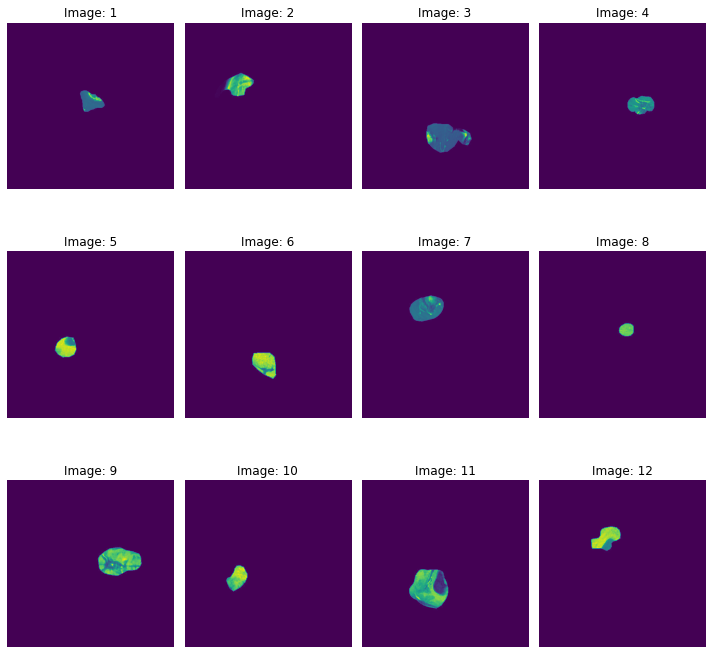

In [10]:
## Visualize few tumor images extracted using binary mask

displayImages(hr_tumors)

In [11]:
## Extract Tumor regions with the help of contours

hr_tumor_regions = []
hr_contours_regions = []
for img in hr_tumors:
    
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ## get the biggest contour
    
    biggest_cntr = max(contours, key = cv2.contourArea)
    img_cpy = img.get().copy()
    
    ## Apply Polygon Curve approximation to extract out the tumor
    
    eps = 0.01 * cv2.arcLength(biggest_cntr, True)
    approx = cv2.approxPolyDP(biggest_cntr, eps, True)
    hr_contours_regions.append(cv2.drawContours(img_cpy, [approx],0,(255,0,0), 3))
    
    ## Bounding Rectangle
    (x,y,w,h) = cv2.boundingRect(biggest_cntr)

    ## Crop the tumor region
    
    hr_tumor_regions.append(img.get()[y:y+h, x:x+w])

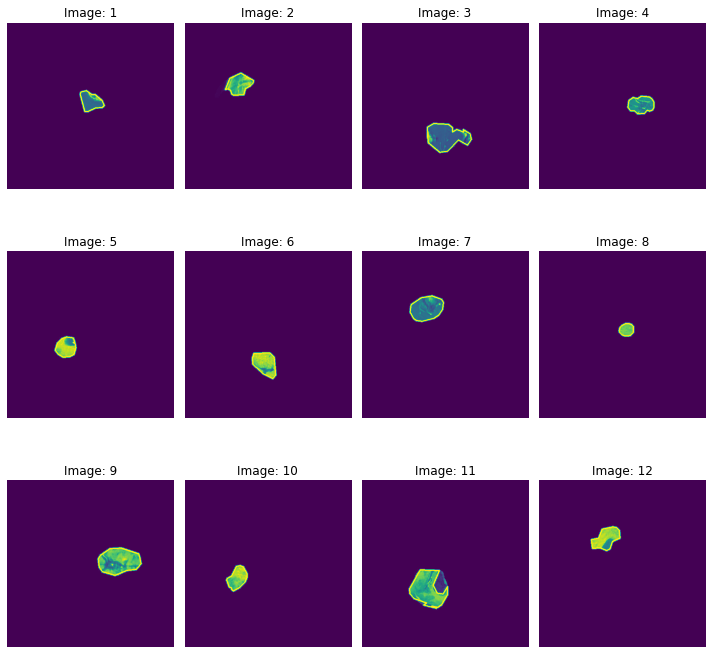

In [12]:
## Visualize tumor images with contour drawn on them

displayImages(hr_contours_regions)

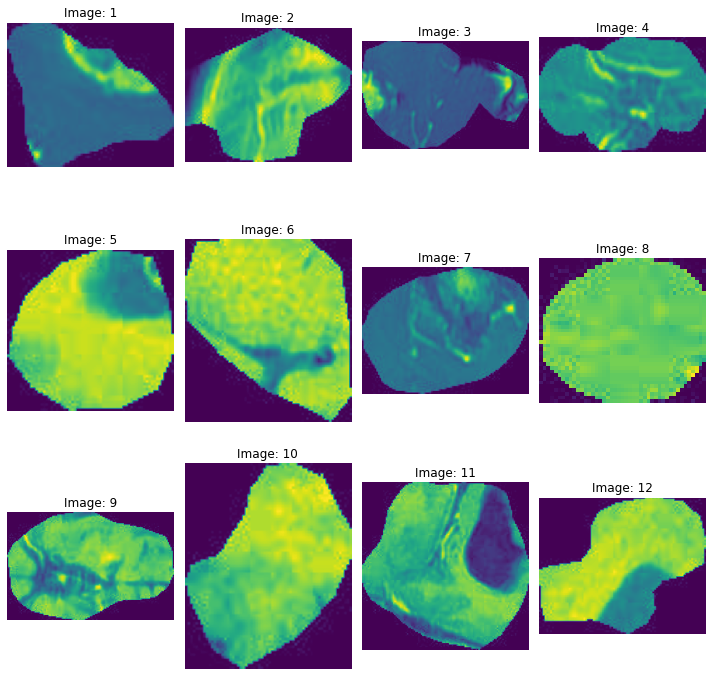

In [13]:
## Visualize extratced tumor regions

displayTumors(hr_tumor_regions)

In [14]:
## Load SR Images from the directory

sr_tumor_files = load_data("../input/espcn-tumor-dataset/sr_tumor/sr_tumor_imgs/", ".jpeg")

directory path:  ../input/espcn-tumor-dataset/sr_tumor/sr_tumor_imgs/
directories:  ['../input/espcn-tumor-dataset/sr_tumor/sr_tumor_imgs/']
list of files:  200
list of files path:  200 file path:  ../input/espcn-tumor-dataset/sr_tumor/sr_tumor_imgs/SRTMR_169.jpeg
Files Read:  200


In [15]:
## Convert each image to UMat in order to apply 

sr_tumors = []
for i in range(len(hr_tumor_files)):
    sr_tumors.append(cv2.cvtColor(cv2.UMat(hr_tumor_files[i]), cv2.COLOR_RGB2GRAY))

### Display SR Tumor Images

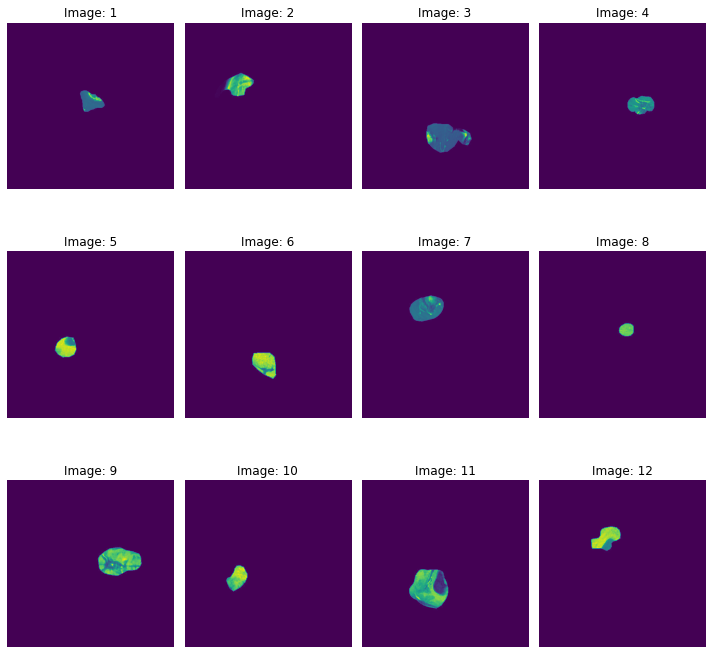

In [16]:
## Display SR Tumors

displayImages(sr_tumors)

In [17]:
## Extract Tumor regions with the help of contours

sr_tumor_regions = []
sr_contours_regions = []
for img in sr_tumors:
    
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ## get the biggest contour
    
    biggest_cntr = max(contours, key = cv2.contourArea)
    img_cpy = img.get().copy()
    
    ## Apply Polygon Curve approximation to extract out the tumor
    
    eps = 0.01 * cv2.arcLength(biggest_cntr, True)
    approx = cv2.approxPolyDP(biggest_cntr, eps, True)
    sr_contours_regions.append(cv2.drawContours(img_cpy, [approx],0,(255,0,0), 3))
    
    ## Bounding Rectangle
    (x,y,w,h) = cv2.boundingRect(biggest_cntr)

    ## Crop the tumor region
    
    sr_tumor_regions.append(img.get()[y:y+h, x:x+w])

### Display Contours on Tumor

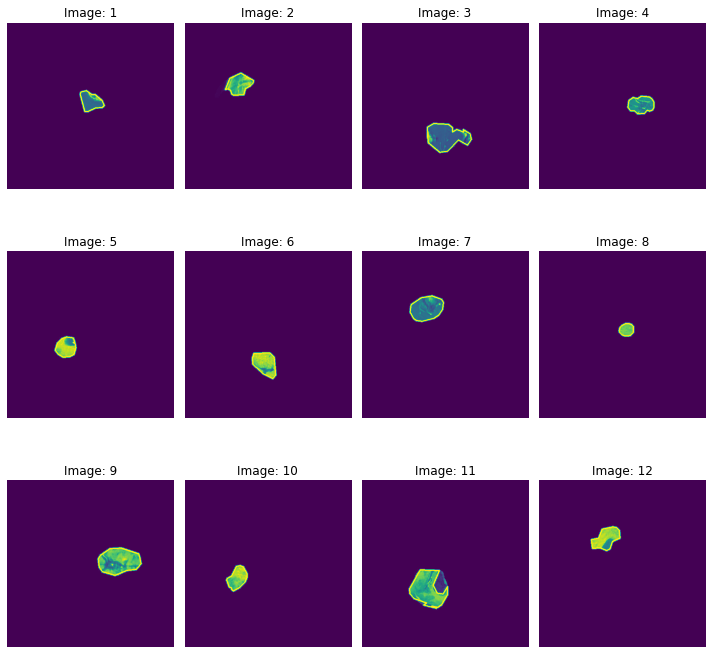

In [18]:
displayImages(sr_contours_regions)

### Display Extracted Tumor Regions

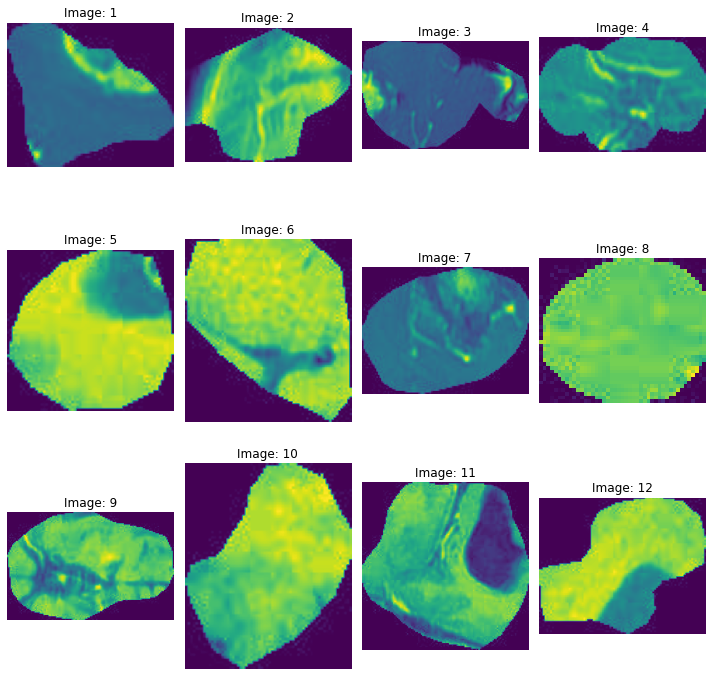

In [19]:
displayTumors(sr_tumor_regions)

### Compute SSIM parameters individually and see the output

In [20]:
## Convert to 1D tensor

img1 = np.squeeze(sr_tumor_regions[0])
img2 = np.squeeze(hr_tumor_regions[0])

In [21]:
## Define constant parameters C1 and C2 for SSIM calcualations

C1 = (0.01 * 255)**2
C2 = (0.03 * 255)**2

## Convert images to float type

img1 = img1.astype(np.float64)
img2 = img2.astype(np.float64)

## Define Gaussian Filter of size 11x11 for smoothening

kernel = cv2.getGaussianKernel(11, 1.5)
window = np.outer(kernel, kernel.transpose())

In [22]:
mu1 = cv2.filter2D(img1, -1, window)  # valid
print("mu1 ", mu1.shape)
print(mu1)

mu1  (65, 75)
[[ 4.91037834e+00  6.10388746e+00  9.74448825e+00 ...  1.14593765e-14
   1.14593765e-14  1.07824366e-14]
 [ 6.14255981e+00  7.88459179e+00  1.29648377e+01 ... -3.15452729e-16
  -6.91545492e-15  2.30672380e-15]
 [ 9.87635752e+00  1.30646152e+01  2.17044220e+01 ...  1.00146114e-14
   4.16611650e-15  1.60947642e-14]
 ...
 [ 2.77901159e-14  2.52637417e-14  3.34744578e-14 ...  4.38378319e-15
   8.65617837e-16  1.40527618e-14]
 [ 9.47390314e-15  1.45266515e-14  1.05791918e-14 ... -2.73104834e-14
  -1.98342048e-14 -9.97798224e-15]
 [ 1.07370902e-14  1.32634644e-14  9.47390314e-15 ...  1.21774390e-14
   3.34241971e-15  1.78767463e-14]]


In [23]:
mu2 = cv2.filter2D(img2, -1, window)
print("mu2 ", mu2.shape)
print(mu2)

mu2  (65, 75)
[[ 4.91037834e+00  6.10388746e+00  9.74448825e+00 ...  1.14593765e-14
   1.14593765e-14  1.07824366e-14]
 [ 6.14255981e+00  7.88459179e+00  1.29648377e+01 ... -3.15452729e-16
  -6.91545492e-15  2.30672380e-15]
 [ 9.87635752e+00  1.30646152e+01  2.17044220e+01 ...  1.00146114e-14
   4.16611650e-15  1.60947642e-14]
 ...
 [ 2.77901159e-14  2.52637417e-14  3.34744578e-14 ...  4.38378319e-15
   8.65617837e-16  1.40527618e-14]
 [ 9.47390314e-15  1.45266515e-14  1.05791918e-14 ... -2.73104834e-14
  -1.98342048e-14 -9.97798224e-15]
 [ 1.07370902e-14  1.32634644e-14  9.47390314e-15 ...  1.21774390e-14
   3.34241971e-15  1.78767463e-14]]


In [24]:
mu1_sq = mu1**2
print("mu1_sq ",mu1_sq.shape)
print(mu1_sq)

mu1_sq  (65, 75)
[[2.41118154e+01 3.72574421e+01 9.49550512e+01 ... 1.31317310e-28
  1.31317310e-28 1.16260939e-28]
 [3.77310410e+01 6.21667877e+01 1.68087015e+02 ... 9.95104242e-32
  4.78235167e-29 5.32097471e-30]
 [9.75424380e+01 1.70684170e+02 4.71081936e+02 ... 1.00292442e-28
  1.73565267e-29 2.59041434e-28]
 ...
 [7.72290541e-28 6.38256645e-28 1.12053932e-27 ... 1.92175551e-29
  7.49294240e-31 1.97480114e-28]
 [8.97548408e-29 2.11023603e-28 1.11919300e-28 ... 7.45862506e-28
  3.93395681e-28 9.95601296e-29]
 [1.15285107e-28 1.75919488e-28 8.97548408e-29 ... 1.48290020e-28
  1.11717695e-29 3.19578058e-28]]


In [25]:
mu2_sq = mu2**2
print("mu2_sq ", mu2_sq.shape)
print(mu2_sq)

mu2_sq  (65, 75)
[[2.41118154e+01 3.72574421e+01 9.49550512e+01 ... 1.31317310e-28
  1.31317310e-28 1.16260939e-28]
 [3.77310410e+01 6.21667877e+01 1.68087015e+02 ... 9.95104242e-32
  4.78235167e-29 5.32097471e-30]
 [9.75424380e+01 1.70684170e+02 4.71081936e+02 ... 1.00292442e-28
  1.73565267e-29 2.59041434e-28]
 ...
 [7.72290541e-28 6.38256645e-28 1.12053932e-27 ... 1.92175551e-29
  7.49294240e-31 1.97480114e-28]
 [8.97548408e-29 2.11023603e-28 1.11919300e-28 ... 7.45862506e-28
  3.93395681e-28 9.95601296e-29]
 [1.15285107e-28 1.75919488e-28 8.97548408e-29 ... 1.48290020e-28
  1.11717695e-29 3.19578058e-28]]


In [26]:
mu1_mu2 = mu1 * mu2
print("mu1_mu2 ", mu1_mu2.shape)
print(mu1_mu2)

mu1_mu2  (65, 75)
[[2.41118154e+01 3.72574421e+01 9.49550512e+01 ... 1.31317310e-28
  1.31317310e-28 1.16260939e-28]
 [3.77310410e+01 6.21667877e+01 1.68087015e+02 ... 9.95104242e-32
  4.78235167e-29 5.32097471e-30]
 [9.75424380e+01 1.70684170e+02 4.71081936e+02 ... 1.00292442e-28
  1.73565267e-29 2.59041434e-28]
 ...
 [7.72290541e-28 6.38256645e-28 1.12053932e-27 ... 1.92175551e-29
  7.49294240e-31 1.97480114e-28]
 [8.97548408e-29 2.11023603e-28 1.11919300e-28 ... 7.45862506e-28
  3.93395681e-28 9.95601296e-29]
 [1.15285107e-28 1.75919488e-28 8.97548408e-29 ... 1.48290020e-28
  1.11717695e-29 3.19578058e-28]]


In [27]:
sigma1_sq = cv2.filter2D(img1**2, -1, window) - mu1_sq
print("sigma1_sq ",sigma1_sq.shape)
print(sigma1_sq)

sigma1_sq  (65, 75)
[[ 1.10761014e+02  1.74719353e+02  3.73793996e+02 ...  1.53023116e-12
   1.57355531e-12  1.29350358e-12]
 [ 1.79432238e+02  2.74438291e+02  5.42244986e+02 ... -1.00635991e-13
  -1.05505767e-13 -4.54244938e-13]
 [ 3.84604267e+02  5.46006914e+02  9.15978736e+02 ... -8.85316942e-13
  -2.86656395e-12 -2.98453557e-13]
 ...
 [ 6.46751788e-13  4.04219867e-13  6.46751788e-13 ... -3.39361716e-12
  -9.67662264e-13 -7.82932927e-13]
 [ 3.63797881e-12  4.04219867e-12  3.51671285e-12 ...  4.41765695e-13
  -1.44761942e-13  6.80974116e-16]
 [ 4.04219867e-12  3.96135470e-12  3.57481945e-12 ... -1.31914700e-12
  -1.49861350e-12 -8.13425275e-13]]


In [28]:
sigma2_sq = cv2.filter2D(img2**2, -1, window) - mu2_sq
print("sigma2_sq ",sigma2_sq.shape)
print(sigma2_sq)

sigma2_sq  (65, 75)
[[ 1.10761014e+02  1.74719353e+02  3.73793996e+02 ...  1.53023116e-12
   1.57355531e-12  1.29350358e-12]
 [ 1.79432238e+02  2.74438291e+02  5.42244986e+02 ... -1.00635991e-13
  -1.05505767e-13 -4.54244938e-13]
 [ 3.84604267e+02  5.46006914e+02  9.15978736e+02 ... -8.85316942e-13
  -2.86656395e-12 -2.98453557e-13]
 ...
 [ 6.46751788e-13  4.04219867e-13  6.46751788e-13 ... -3.39361716e-12
  -9.67662264e-13 -7.82932927e-13]
 [ 3.63797881e-12  4.04219867e-12  3.51671285e-12 ...  4.41765695e-13
  -1.44761942e-13  6.80974116e-16]
 [ 4.04219867e-12  3.96135470e-12  3.57481945e-12 ... -1.31914700e-12
  -1.49861350e-12 -8.13425275e-13]]


In [29]:
sigma12 = cv2.filter2D(img1 * img2, -1, window) - mu1_mu2
print("sigma12 ",sigma12.shape)
print(sigma12)

sigma12  (65, 75)
[[ 1.10761014e+02  1.74719353e+02  3.73793996e+02 ...  1.53023116e-12
   1.57355531e-12  1.29350358e-12]
 [ 1.79432238e+02  2.74438291e+02  5.42244986e+02 ... -1.00635991e-13
  -1.05505767e-13 -4.54244938e-13]
 [ 3.84604267e+02  5.46006914e+02  9.15978736e+02 ... -8.85316942e-13
  -2.86656395e-12 -2.98453557e-13]
 ...
 [ 6.46751788e-13  4.04219867e-13  6.46751788e-13 ... -3.39361716e-12
  -9.67662264e-13 -7.82932927e-13]
 [ 3.63797881e-12  4.04219867e-12  3.51671285e-12 ...  4.41765695e-13
  -1.44761942e-13  6.80974116e-16]
 [ 4.04219867e-12  3.96135470e-12  3.57481945e-12 ... -1.31914700e-12
  -1.49861350e-12 -8.13425275e-13]]


In [30]:
ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
print("ssim_map ",ssim_map.shape)
print(ssim_map)

ssim_map  (65, 75)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [31]:
# def SSIM(img1, img2):
#     C1 = (0.01 * 255)**2
#     C2 = (0.03 * 255)**2

#     img1 = img1.astype(np.float64)
#     img2 = img2.astype(np.float64)
#     kernel = cv2.getGaussianKernel(11, 1.5)
#     window = np.outer(kernel, kernel.transpose())
    
# #     print((cv2.filter2D(img1, -1, window)).shape)
# #     print((cv2.filter2D(img1, -1, window)[5:-5, 5:-5]).shape)

#     mu1 = cv2.filter2D(img1, -1, window)  # valid
#     mu2 = cv2.filter2D(img2, -1, window)
#     mu1_sq = mu1**2
#     mu2_sq = mu2**2
#     mu1_mu2 = mu1 * mu2
#     sigma1_sq = cv2.filter2D(img1**2, -1, window) - mu1_sq
#     sigma2_sq = cv2.filter2D(img2**2, -1, window) - mu2_sq
#     sigma12 = cv2.filter2D(img1 * img2, -1, window) - mu1_mu2
    
# #     mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
# #     mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
# #     mu1_sq = mu1**2
# #     mu2_sq = mu2**2
# #     mu1_mu2 = mu1 * mu2
# #     sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
# #     sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
# #     sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

#     ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
#                                                             (sigma1_sq + sigma2_sq + C2))
# #     return ssim_map.mean()
#     return ssim_map

In [32]:
def SSIM(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)  # valid
    mu2 = cv2.filter2D(img2, -1, window)
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window) - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window) - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [33]:
SSIM(np.squeeze(sr_tumor_regions[0]), np.squeeze(hr_tumor_regions[0]))

1.0

### Verifying our results with the standard ssim module available in skimage.metrics 

In [34]:
## Import SSIM from skimage

from skimage.metrics import structural_similarity as ssim

In [35]:
ssim(sr_tumor_regions[0],hr_tumor_regions[0])

1.0

In [36]:
## Compute SSIM for all the SR Images with respect to HR Images and store the result for each image in the list

ssim_arr = []
for sr_img, hr_img in zip(sr_tumor_regions,hr_tumor_regions):
    ssim_arr.append(SSIM(np.squeeze(sr_img), np.squeeze(hr_img)))

In [37]:
## Print the results

print(ssim_arr)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]